In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataloader import prepare_data_loader
from obspy import read
from scipy import signal
from matplotlib import cm
import os
from Models import Encoder, Classifier

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
training_data_dir = './data/lunar/training/data/S12_GradeA/'
training_labels_file = './data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv'

train_loader = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=training_data_dir,
                                  labels_file_path=training_labels_file)

In [4]:
height, width = train_loader.dataset.tensors[0].shape[1:]

In [5]:
hidden_size = 100
classifier = Classifier(hidden_size).to(device)
encoder = Encoder(hidden_size).to(device)
encoder.load_state_dict(torch.load('./models/encoder.pth', weights_only=False))

In [ ]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5)
criterion = nn.BCELoss()

num_epochs = 100
all_losses = []
classifier.train()
for epoch in range(num_epochs):
    for x, y in train_loader:
        x = x.reshape(-1, 1, height, width).to(device)
        y = y.float().to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        preds = preds.view(-1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch [{epoch + 1}/{num_epochs}], loss: {loss.item()}')
    all_losses.append(loss.item())

torch.save(classifier, './models/classifier.pth')
plt.plot(all_losses)
plt.yscale('log')
plt.show()

In [109]:
thr_loader = torch.utils.data.DataLoader(train_loader.dataset.tensors[0], batch_size=1)
classifier.eval()
preds_list = []
with torch.no_grad():
    for x in thr_loader:
        x = x.reshape(-1, 1, height, width).to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        preds = preds.view(-1)
        preds_list.append(preds.item())
preds_list = torch.tensor(preds_list)

In [118]:
max_fscore = 0
for thr in range(1, 100):
    threshold = thr / 100
    preds = preds_list > threshold
    true_positives = (preds & train_loader.dataset.tensors[1].bool()).sum().item()
    false_positives = (preds & ~train_loader.dataset.tensors[1].bool()).sum().item()
    false_negatives = (~preds & train_loader.dataset.tensors[1].bool()).sum().item()
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    fscore = 2 * precision * recall / (precision + recall)
    if max_fscore < fscore:
        max_fscore = fscore
        best_thr = threshold
print(f'Threshold: {best_thr}, Fscore: {max_fscore:.2f}')

Threshold: 0.82, Fscore: 0.91


In [ ]:
test_data_dir = './data/lunar/test/data/S12_GradeB/'

spctrs, enc_dates = prepare_data_loader(overlap=0.25,
                                  window_length=1,
                                  decimation_factor=3,
                                  spect_nfft=128,
                                  spect_nperseg=128,
                                  batch_size=128,
                                  data_dir=test_data_dir,
                                  one_file=True)

In [61]:
testset = torch.utils.data.TensorDataset(torch.tensor(spctrs))
test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [63]:
dates = [(date[0].strftime('%Y-%m-%d %H:%M:%S'), date[1].strftime('%Y-%m-%d %H:%M:%S')) for date in enc_dates]

In [122]:
date_to_pred, date_to_spc = {}, {}
classifier.eval()
with torch.no_grad():
    for i, spc in enumerate(test_loader):
        x = spc[0].float().reshape(-1, 1, height, width).to(device)
        embedding = encoder(x)
        embedding = embedding.view(embedding.size(0), -1)
        preds = classifier(embedding)
        date_to_pred[dates[i]] = preds.item() > best_thr
        date_to_spc[dates[i]] = spc[0]

In [125]:
num_file = 0
data_directory = './data/lunar/test/data/S12_GradeB/'
for i, file in enumerate(os.listdir(data_directory)):
    if file.endswith('.mseed'):
        if i // 2 == num_file:
            print(file)
            mseed_file = f'{data_directory}{file}'
            st = read(mseed_file)
            break

xa.s12.00.mhz.1969-12-16HR00_evid00006.mseed


1969-12-16 00:00:00


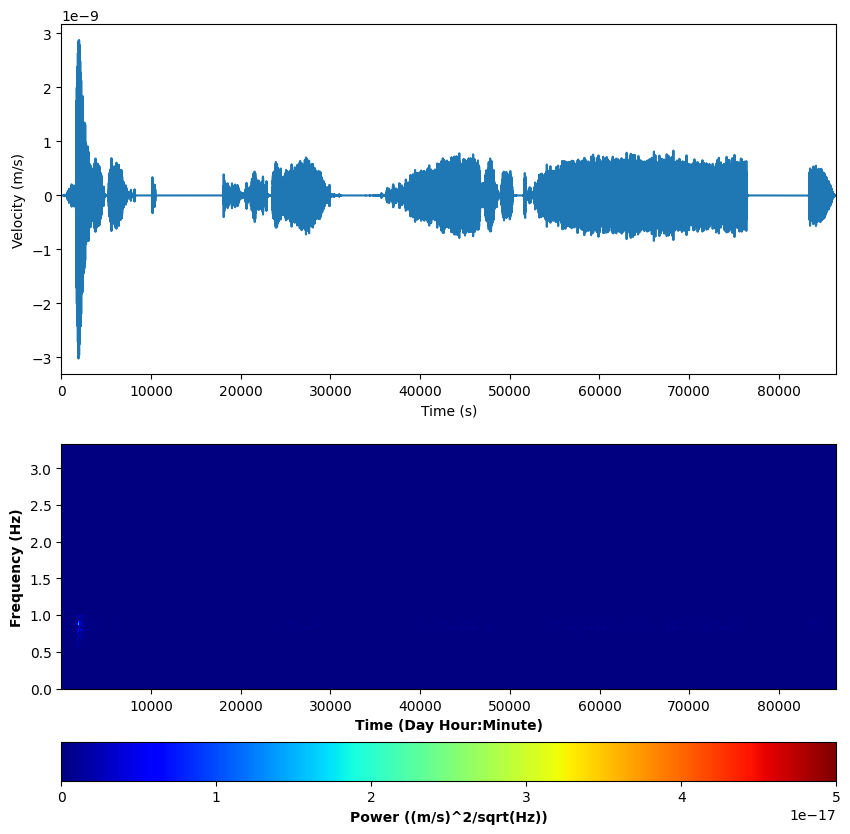

In [126]:
st_filt = st.copy()
st_filt.filter('bandpass', freqmin=0.5, freqmax=1.0)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr = st.traces[0].copy()
tr_times = tr.times()
starttime = tr.stats.starttime.datetime
print(starttime.strftime('%Y-%m-%d %H:%M:%S'))
tr_data_filt = tr_filt.data

f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
ax.plot(tr_times_filt, tr_data_filt)

ax.set_xlim([min(tr_times_filt), max(tr_times_filt)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')

ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')